In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az
import pandas as pd
import seaborn as sns

%matplotlib inline
from IPython.display import Math, Latex

# The tips dataset

To explore the subject matter of this section, we are going to use the tips dataset. This data was reported for the first time by Bryant, P. G. and Smith, M (1995) in Practical Data Analysis: Case Studies in Business Statistics.

We want to study the effect of the day of the week on the amount of tips at a restaurant. For this example, the different groups are the days. Notice there is no control group or treatment group. If we wish, we can arbitrarily establish one day, for example, Thursday, as the reference or control. For now, let's start the analysis by loading the dataset as a pandas DataFrame using just one line of code. If you are not familiar with pandas, the tail command is used to show the last rows of a DataFrame (you can also try using head):

In [4]:
#print(data)
#stats.describe(data)
tips = pd.read_csv('./data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


From this DataFrame, we are only going to use the day and tip columns.

/Users/m102417/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


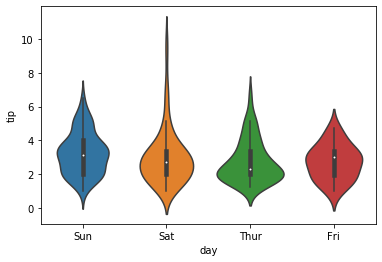

In [22]:
sns.violinplot(x='day', y='tip', data=tips)

Just to simplify things, we are going to create three variables: the y variable, representing the tips, the idx variable, a categorical dummy variable to encode the days with numbers, that is, [0, 1, 2, 3] instead of [Thursday, Friday, Saturday, Sunday], and finally the groups variable, with the number of groups (4):

In [24]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

The model for this problem is almost the same as model_g; the only difference is that now sigma and mu are going to be vectors instead of scalar variables PyMC3 syntax is extremely helpful for this situation: instead of writing for loops, we can write our model in a vectorized way. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sds variables using the idx variable:

???

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:11<00:00, 1956.58draws/s]
/Users/m102417/anaconda3/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c30229320>,
      dtype=object)

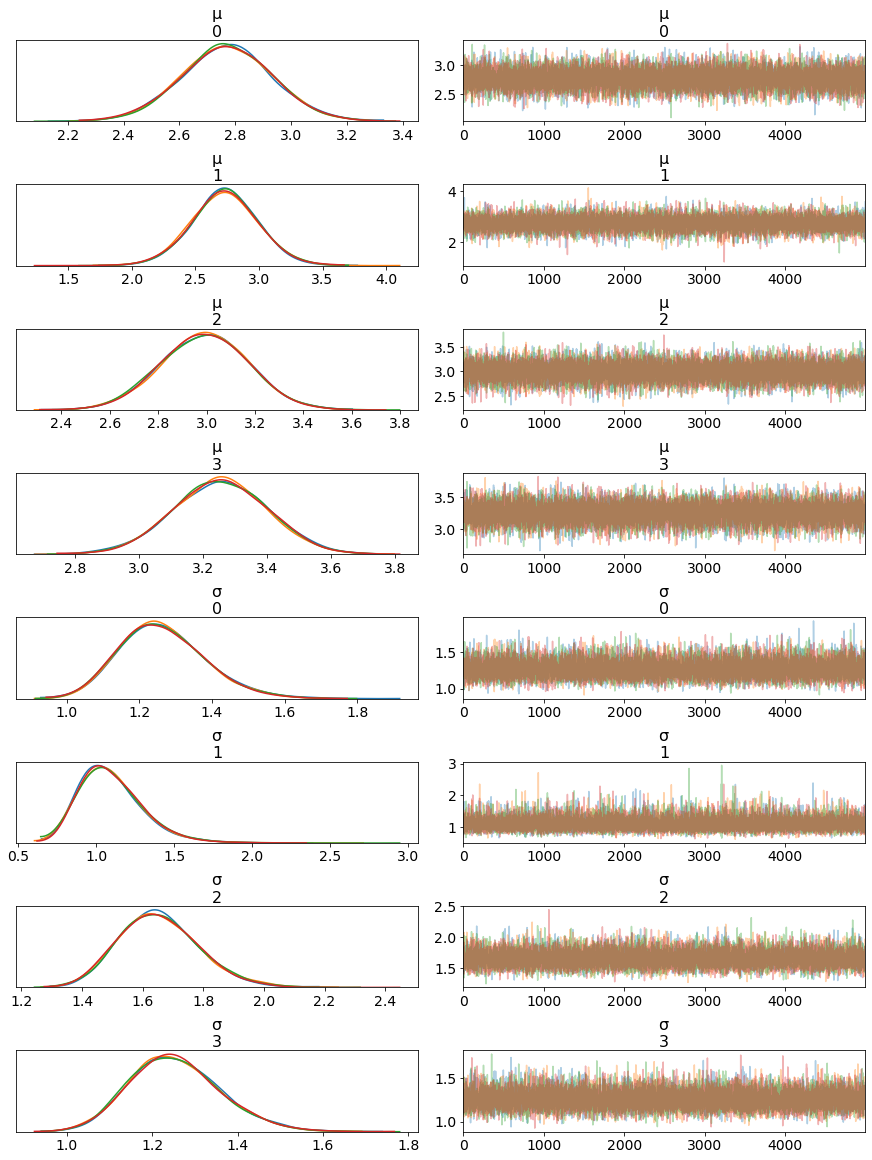

In [25]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

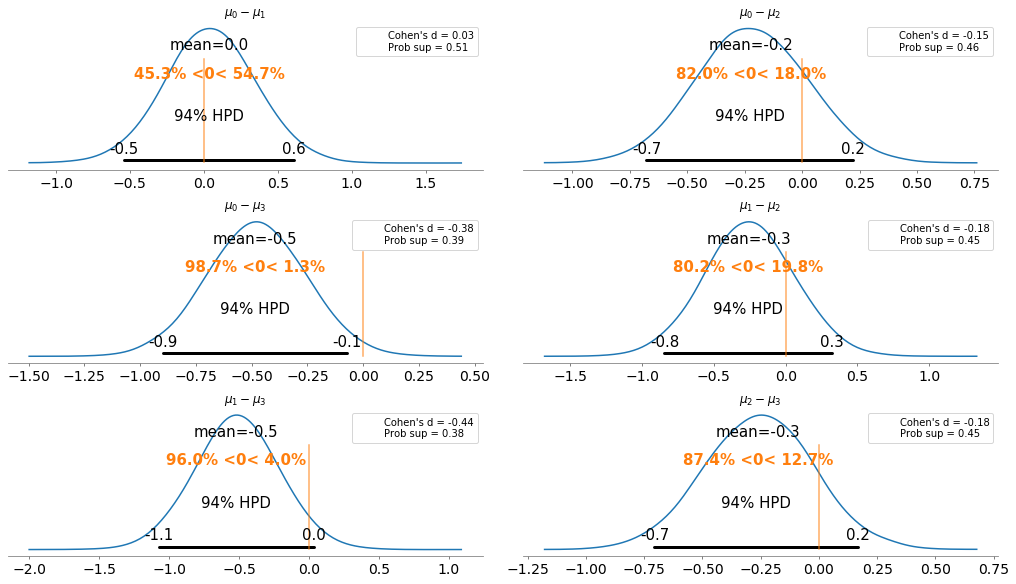

In [26]:
#The following code is just a way of plotting the difference without repeating the comparison. 
#Instead of plotting the all-against-all matrix, we are just plotting the upper triangular portion:

dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

One way to interpret these results is by comparing the reference value with the HPD interval. According to the previous diagram, we have only one case when the 94% HPD excludes the reference value of zero, that is, the difference in tips between Thursday and Sunday. For all the other examples, we cannot rule out a difference of zero (according to the HPD-reference-value-overlap criteria). But even for that case, is an average difference of ≈0.5 dollars large enough? Is that difference enough to accept working on Sunday and missing the opportunity to spend time with family or friends? Is that difference enough to justify averaging the tips over the four days and giving every waitress and waiter the same amount of tip money? Those kinds of questions cannot be answered by statistics; they can only be informed by statistics.